# Sobre
Este notebook foi usado para registrar os testes utilizados nas chamadas de API do Gemini.

O Gemini foi usado neste projeto com o objetivo de extrair informações do campo "Objeto" das licitações. Este campo descrivte em linguagem natural qual é o obtetivo da licitação, e nele espera-se que sempre contenha o produto ou serviço que está sendo licitado e pode-se ou não ser informada qual secretaria da prefeitura criou esta licitação.

Espera-se que o Gemini possa extrair estes dois campos de forma estruturada do texto.

O processo de testes aqui documentado iniciou-se após o banco de dados estar pronto.
O idioma utilizado para as anotações é o português devido ao fato de que este notebook não ser essencial para o funcionamento do código, a principal finalidade dele é documentar o processo de ajuste do prompty usado para extrair as informações do Gemini.

# Preparação
Todos os  requisitos decritps no README.md devem ser instalados e o arquivo ```main.py``` deve ser executado antes de começar, para a devida consulta dos dados no site das prefeituras.
Após a preparação do ambinete pode-se iniciar os testes de extração de dados pelo 

## Inicialização da Classe
Nesta etapa a classe contendo os dados da prefeitura foi iniciada, para que os dados obtidos através do arquivos ```main.py```possam ser consultados.

In [1]:
from Scraping import *

cw_ponta_grossa = crawlers.CrawlerMaster(1, 'cmpg.oxy.elotech.com.br', 4119905, 'Ponta Grossa', 'PR')
cw_eng_beltrao = crawlers.CrawlerMaster(1, 'engenheirobeltrao.oxy.elotech.com.br', 4107504, 'Engenheiro Beltrão', 'PR')

import nest_asyncio
nest_asyncio.apply()

## __init__ crawlers load: oxy
## Starting Scraping.crawlers.crawler_oxy ##
## Starting Scraping.crawlers.crawler_base ##
## __init__ crawlers load: base
## __init__ crawlers load: master
## Starting Scraping.crawlers.crawler_master ##


# BERT
Antes do Gemini ser escolhido para este projeto, o BERT foi considerado, abaixo estão os testes realizados com a API dele.

In [1]:
import torch
from transformers import AutoTokenizer,AutoModelForPreTraining, AutoModel

model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)
input_ids = tokenizer.encode('Tinha uma pedra no meio do caminho.', return_tensors='pt')

with torch.no_grad():
    outs = model(input_ids)
    encoded = outs[0][0, 1:-1]

last_hidden_states = outs[0]

# Print the output features
print(last_hidden_states)

c:\Users\danie\OneDrive\7 - Estudos\3 - MBA USP 2022\6 - TCC\Code\GovBrProcurement\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([[[ 0.2824, -0.1887,  0.5604,  ..., -0.6297,  0.0302, -0.5707],
         [-0.0398, -0.3057,  0.2431,  ..., -0.5420,  0.1857, -0.5775],
         [-0.2926, -0.1957,  0.7020,  ..., -0.2843,  0.0530, -0.4304],
         ...,
         [ 0.0662,  0.2845,  0.1871,  ..., -0.2542, -0.2933, -0.0661],
         [ 0.2761, -0.1657,  0.3288,  ..., -0.2102,  0.0029, -0.2009],
         [ 0.2825, -0.1884,  0.5614,  ..., -0.6288,  0.0294, -0.5712]]])


In [4]:
encoded.size()

torch.Size([8, 768])

In [2]:
cw.create_city()

IntegrityError: UNIQUE constraint failed: CITYS.ibge

## Arquivos em PDF e OCR
Além do campo "Objeto" presente na API, arquivos em PDF são anexados ao processo de licitação. Estes arquivos geralemtne são scaners de documentos contendo várias páginas.

Neste ponto dos testes considerava-se utilizar estes PDFs para extração destes campos, visto que o campo 'objetivo' nem sempre trazia a informação do orgão que abriu a licitação. Entretanto como pode ser visto abaixo, este processo foi descartado devido ao limite de tokenização destes modelos e da quantidade de palavras extraidas via OCR destes arquivos PDFs.

In [10]:
import torch
from transformers import AutoTokenizer,AutoModelForPreTraining, AutoModel, pipeline, BertTokenizer
from torch.nn import functional as F
import sqlite3

con = sqlite3.connect("scraped.db", timeout=50)
cur = con.cursor()
cur.execute("SELECT OCR_RAW FROM FILES LIMIT 1", ())

rows = cur.fetchall()
test = rows[0][0]
#print(test)

complement = '\nO texto acima trata-se de uma licitação [MASK].'

sentence = test + complement
MAX_LENGTH = 512000
model = AutoModelForPreTraining.from_pretrained('neuralmind/bert-large-portuguese-cased')
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

df_token = tokenizer.batch_encode_plus([sentence], return_tensors='pt' , padding=True, max_length=MAX_LENGTH)

print(df_token)

c:\Users\danie\OneDrive\7 - Estudos\3 - MBA USP 2022\6 - TCC\Code\GovBrProcurement\venv\Lib\site-packages\transformers\tokenization_utils_base.py:2636: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


RuntimeError: The size of tensor a (18577) must match the size of tensor b (512) at non-singleton dimension 1

In [16]:
x = torch.stack((df_token['input_ids'], df_token['attention_mask']), dim=0)

In [17]:
df_token

{'input_ids': tensor([[  101, 17715,  4790,  ...,   103,   119,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]])}

In [1]:
from transformers import BertTokenizer, BertForQuestionAnswering
import torch

def responder_perguntas_bert(texto, perguntas):
    tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
    model = BertForQuestionAnswering.from_pretrained('neuralmind/bert-base-portuguese-cased')

    respostas = {}

    for i, pergunta in enumerate(perguntas, start=1):
        inputs = tokenizer(texto, pergunta, return_tensors="pt")
        outputs = model(**inputs)
        answer_start = torch.argmax(outputs.start_logits)
        answer_end = torch.argmax(outputs.end_logits) + 1
        resposta = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][answer_start:answer_end]))

        respostas[f"Resposta {i}"] = resposta

    return respostas

# Exemplos
input1 = "O objetivo da licitação é: Aquisição de 02 bebedouros para a Escola Maria Medeiros."
perguntas1 = [
    "Qual secretaria solicitou a compra de materiais?",
    "Quais produtos e/ou serviços estão listados no objetivo da licitação e qual a sua quantidade?"
]

respostas1 = responder_perguntas_bert(input1, perguntas1)
for pergunta, resposta in respostas1.items():
    print(f"{pergunta}: {resposta}")

input2 = "O objetivo da licitação é: Aquisição de 04 cortadores de grama 6,5 HP para a Secretária de Obras e urbanização e 01 lavadora profissional de alta pressão com funcionamento por pistão para a Escola Municipal Elmira Rodrigues."
perguntas2 = [
    "Qual secretaria solicitou a compra de materiais?",
    "Quais produtos e serviços estão listados no objetivo da licitação?"
]

respostas2 = responder_perguntas_bert(input2, perguntas2)
for pergunta, resposta in respostas2.items():
    print(f"{pergunta}: {resposta}")

c:\Users\danie\OneDrive\7 - Estudos\3 - MBA USP 2022\6 - TCC\Code\GovBrProcurement\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Resposta 1: 
Resposta 2: 


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Resposta 1: 
Resposta 2: 


In [2]:
from transformers import BertTokenizer, BertForQuestionAnswering
from torch.utils.data import DataLoader, Dataset
import torch

class QADataset(Dataset):
    def __init__(self, texts, questions, answers):
        self.texts = texts
        self.questions = questions
        self.answers = answers

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            "text": self.texts[idx],
            "question": self.questions[idx],
            "answer": self.answers[idx]
        }

# Usando o Gemini
A partir deste ponto ficou claro que o uso de uma LLM mais atualizado deveria ser usado para o proejto. Com isso iniciaram-se os testes com o Gemini.

## Gemini via web
Inicialmente os testes foram feitos diretamente na versão web do site __[Gemini App](https://gemini.google.com/app)__.

O prompt inicial foi:
```
Irei te passar alguns textos e preciso que extraia deles qual produto ou serviço está sendo licitado e qual o orgão que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente e separe a primeira parte da pergunta da segunda com ponto e vírcula (semicolon).
Alguma dúvida ou podemos começar?
```
Trazendo como resultado:
```
Sem dúvidas, podemos começar! Aguardo os textos para que eu possa extrair as informações sobre produtos ou serviços licitados e o órgão responsável pela licitação. 

**Lembre-se:**

* Se o texto não mencionar o produto ou serviço, responderei "**Produto/Serviço não informado**".
* Se o texto não mencionar o órgão solicitante, responderei "**Órgão solicitante não informado**".

**Exemplo de resposta:**

* **Produto/Serviço:** [Nome do produto ou serviço]
* **Órgão solicitante:** [Nome do órgão]

**Formato de envio dos textos:**

* Você pode enviar os textos um por um ou todos de uma vez.
* Se enviar um por um, basta colar o texto na caixa de diálogo.
* Se enviar todos de uma vez, pode enviar um arquivo de texto (.txt) ou um documento do Google Docs.

**Pronto para começar?**

Envie os textos quando estiver pronto e farei a extração das informações o mais rápido possível.

```

Em seguida a seguinte prompt foi passada:
```
Aquisição de motor usado para o veículo caminhão Ford - Cargo - frota 1503 modelo: Cummins nº 30.441945 série: C 320CV, da Secretaria Municipal de Obras, Viação e Serviços Públicos.
 Registro de preços, para futura e eventual aquisição de kit de alimentação social, para a Secretaria Municipal de Assistência e Desenvolvimento Social. 
 (... outros 21 'campos objetos' foram passados)
```
E o retorno foi:
```
Extração de informações de licitações
1. Motor usado para caminhão Ford Cargo

Produto/Serviço: Motor usado
Órgão solicitante: Secretaria de Obras, Viação e Serviços Públicos
2. Kit de alimentação social

Produto/Serviço: Kit de alimentação social
Órgão solicitante: Secretaria de Assistência e Desenvolvimento Social

(... outros 21 campos com a mesma formatação)
```

Por fim, poi passado:

```
Poderia tabular estes dados em 2 colunas uma para cada resposta?
```
O que retornou o seguinte:

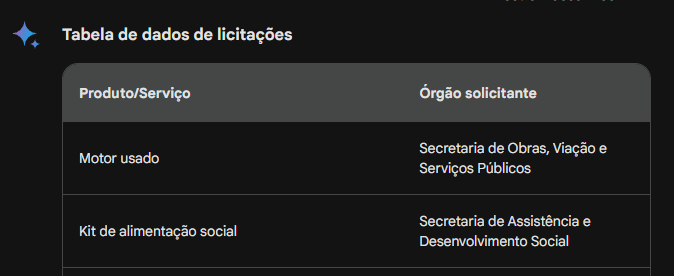

```(e outros 21 itens com a mesma formatação)```

## Gemini API
Com isso pode-se constatar que o modelo poderia ser capaz de apresentar os resultados esperados.

Desta forma iniciaram-se os testes com a API descritos nesta seção do notebook.

### Tentativa 1

In [6]:
import google.generativeai as genai
import json

with open('config.json') as config_file:
    paths = json.load(config_file)

API_KEY = paths['genai_key']
# https://aistudio.google.com/app/apikey
genai.configure(api_key=API_KEY)

model = genai.GenerativeModel('gemini-pro')

In [5]:
context_prompt = 'Irei te passar alguns textos e preciso que extraia deles qual produto ou serviço está sendo licitado e qual o órgão que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". As respostas precisam estar tabeladas uma coluna para cada pergunta. Alguma dúvida ou podemos começar?'
response = model.generate_content(context_prompt)
print(response.text)

Claro, podemos começar. Não hesite em me informar se tiver alguma dúvida.

| Produto ou Serviço | Órgão Solicitante |
|---|---|
| Não informado | Prefeitura Municipal de São Paulo |
| Computadores e notebooks | Universidade Federal do Rio de Janeiro |
| Material de escritório | Secretaria de Estado da Saúde do Paraná |
| Veículos automotores | Departamento Estadual de Trânsito de Minas Gerais |
| Serviços de limpeza e conservação | Hospital das Clínicas da Universidade de São Paulo |
| Obras de construção civil | Governo do Estado do Rio Grande do Sul |
| Equipamentos médicos | Ministério da Saúde |
| Móveis e utensílios | Câmara Municipal de Curitiba |
| Serviços de TI | Tribunal de Justiça do Estado de São Paulo |
| Materiais de construção | Prefeitura Municipal de Salvador |
| Serviços de engenharia | Departamento Nacional de Infraestrutura de Transportes |
| Material esportivo | Secretaria de Estado da Educação do Rio de Janeiro |
| Serviços de manutenção e reparos | Companhia Paul

In [7]:
Test_prompt = []

Test_prompt.append("Aquisição de motor usado para o veículo caminhão Ford - Cargo - frota 1503 modelo: Cummins nº 30.441945 série: C 320CV, da Secretaria Municipal de Obras, Viação e Serviços Públicos.")
Test_prompt.append("Registro de preços, para futura e eventual aquisição de kit de alimentação social, para a Secretaria Municipal de Assistência e Desenvolvimento Social.")
Test_prompt.append("Aquisição de 2000 brinquedos (super giro pião com laçador), para distribuição às crianças em comemoração ao Natal, pela Secretaria Municipal de Assistência e Desenvolvimento Social.")
Test_prompt.append("Registro de preços, pelo prazo de 12 meses, para futura e eventual aquisição de suplementos e fórmulas especiais para pacientes com deficiência e tratamento de câncer atendidos pela Secretaria Municipal de Saúde.")

response = model.generate_content(Test_prompt)
print(response.text)

* Aquisição de motor usado para o veículo caminhão Ford - Cargo - frota 1503 modelo: Cummins nº 30.441945 série: C 320CV, da Secretaria Municipal de Obras, Viação e Serviços Públicos.

* Registro de preços, para futura e eventual aquisição de kit de alimentação social, para a Secretaria Municipal de Assistência e Desenvolvimento Social.

* Aquisição de 2000 brinquedos (super giro pião com laçador), para distribuição às crianças em comemoração ao Natal, pela Secretaria Municipal de Assistência e Desenvolvimento Social.

* Registro de preços, pelo prazo de 12 meses, para futura e eventual aquisição de suplementos e fórmulas especiais para pacientes com deficiência e tratamento de câncer atendidos pela Secretaria Municipal de Saúde.


Como o resultado não foi o esperado, foram alimentados manualmente 10 itens como exemplo no banco de dados

In [4]:
list_id = ['27/2023/6', '26/2023/6', '25/2023/6', '24/2023/6', '23/2023/6']
list_new_ex1 = ['Internet com link dedicado', 'Puxadores para janelas tipo “Maxim ar”', 'Relógio protocolador eletrônico', 'Serviços de Saúde e Segurança do Trabalho', 'Refrigeradores tipo frigobar']
list_new_ex2 = ['Não informado', 'Não informado', 'Não informado', 'Não informado', 'Não informado']
cw_ponta_grossa.update_procurements_filed('Extra1', list_id, list_new_ex1) #4119905
cw_ponta_grossa.update_procurements_filed('Extra2', list_id, list_new_ex2) #4119905


list_id = ['95/2023/7', '95/2023/6', '93/2023/7', '94/2023/6', '92/2023/7']
list_new_ex1 = ['Motor usado para o veículo caminhão Ford', 'Kit de alimentação social', 'Brinquedos (super giro pião com laçador)', 'Suplementos e fórmulas especiais para pacientes com deficiência e tratamento de câncer', 'Serviço de caminhão munk']
list_new_ex2 = ['Secretaria Municipal de Obras, Viação e Serviços Públicos', 'Secretaria Municipal de Assistência e Desenvolvimento Social', 'Secretaria Municipal de Assistência e Desenvolvimento Social', 'Secretaria Municipal de Saúde', 'Secretaria de Obras e Urbanização']
cw_eng_beltrao.update_procurements_filed('extra1', list_id, list_new_ex1) #4107504
cw_eng_beltrao.update_procurements_filed('extra2', list_id, list_new_ex2) #4107504

### Tentativa 2
Agora podemos ajustar a prompt passando os exemplos registrados no banco de dados.

In [10]:
sample1 = cw_ponta_grossa.query_produrements_goal(limit=10, fields='extra1, extra2', filter="extra1 <> ''")
sample2 = cw_eng_beltrao.query_produrements_goal(limit=10, fields='extra1, extra2', filter="extra1 <> ''")
sample1.extend(sample2)
sample1

[(4119905,
  '23/2023/6',
  2023,
  6,
  23,
  '... a “aquisição de 08(oito) refrigeradores tipo FRIGOBAR”, ...',
  'Refrigeradores tipo frigobar',
  'Não informado'),
 (4119905,
  '24/2023/6',
  2023,
  6,
  24,
  'Contratação de empresa especializada para Prestação de Serviços de Saúde e Segurança do Trabalho ...',
  'Serviços de Saúde e Segurança do Trabalho',
  'Não informado'),
 (4119905,
  '25/2023/6',
  2023,
  6,
  25,
  '... contratação de empresa habilitada para fornecimento de “01 (um) RELÓGIO PROTOCOLADOR ELETRÔNICO”',
  'Relógio protocolador eletrônico',
  'Não informado'),
 (4119905,
  '26/2023/6',
  2023,
  6,
  26,
  '... fornecimento de “PUXADORES PARA JANELAS TIPO “MAXIM AR”,...',
  'Puxadores para janelas tipo “Maxim ar”',
  'Não informado'),
 (4119905,
  '27/2023/6',
  2023,
  6,
  27,
  'Serviços de Internet com link dedicado para o Prédio Sede da CMPG.',
  'Internet com link dedicado',
  'Não informado'),
 (4107504,
  '92/2023/7',
  2023,
  7,
  92,
  'Contratação

In [24]:
sample = cw_ponta_grossa.query_produrements_goal(limit=10, fields='extra1, extra2', filter="extra1 <> ''")
sample2 = cw_eng_beltrao.query_produrements_goal(limit=10, fields='extra1, extra2', filter="extra1 <> ''")
sample.extend(sample2)

context_prompt = 'Irei te passar alguns textos e preciso que extraia deles qual produto ou serviço está sendo licitado e qual o órgão que o solicitou.' + chr(10)
context_prompt += 'É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado".' + chr(10)
context_prompt += 'As respostas precisam estar tabeladas uma coluna para cada item, separadas por pipe sem cabeçalho, informando na primeira coluna o id.' + chr(10)
context_prompt += 'Segue abaixo 10 inputs de exemplo:'  + chr(10)

for objeto in sample:
    context_prompt += chr(10) + '"' + objeto[5].replace('"', "'") + '"'

context_prompt += chr(10) + chr(10) +'E o output deve ser:' + chr(10)

for objeto in sample:
    context_prompt += chr(10) + '"' + objeto[6].replace('"', "'").replace('|', "/") + '"' + '|' +  '"' + objeto[7].replace('"', "'").replace('|', "/") + '"'

context_prompt += chr(10) + chr(10) +'Posso passar os textos para extração?'

print(context_prompt)

Irei te passar alguns textos e preciso que extraia deles qual produto ou serviço está sendo licitado e qual o órgão que o solicitou.
É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado".
As respostas precisam estar tabeladas uma coluna para cada item, separadas por pipe sem cabeçalho, informando na primeira coluna o id.
Segue abaixo 10 inputs de exemplo:

"... a “aquisição de 08(oito) refrigeradores tipo FRIGOBAR”, ..."
"Contratação de empresa especializada para Prestação de Serviços de Saúde e Segurança do Trabalho ..."
"... contratação de empresa habilitada para fornecimento de “01 (um) RELÓGIO PROTOCOLADOR ELETRÔNICO”"
"... fornecimento de “PUXADORES PARA JANELAS TIPO “MAXIM AR”,..."
"Serviços de Internet com link dedicado para o Prédio Sede da CMPG."
"Contratação de serviço de caminhão munk para serviços necessários na secretaria de obras e urbanização, tais como transporte de calhetão da fábrica de tubos ao lixão e troca

In [25]:
model = genai.GenerativeModel('gemini-pro')

response = model.generate_content(context_prompt)
print(response.text)

Sim, você pode passar os textos para extração. 

Os textos podem estar em muitos formatos diferentes. Porém, para evitar perda de dados durante o envio, recomendo que sejam enviados em formato .txt, .pdf ou .docx. Após o envio, iniciarei a extração das informações solicitadas.


In [26]:
sample = cw_ponta_grossa.query_produrements_goal(limit=10, fields='extra1, extra2')
sample2 = cw_eng_beltrao.query_produrements_goal(limit=10, fields='extra1, extra2')
sample.extend(sample2)

Test_prompt = [linha[5] for linha in sample]

response = model.generate_content(Test_prompt)
print(response.text)

- CONTRATAÇÃO DE EMPRESA HABILITADA NO FORNECIMENTO DO OBJETO MATERIAL DE MANUTENÇÃO (LOTE 01 TINTAS E LOTE 02 ESCADAS)


- 98,60 METROS QUADRADOS DE PELÍCULA ESPELHADA DE PROTEÇÃO SOLAR (INSULFILM) COM GARANTIA DE DOIS ANOS, INCLUINDO SERVIÇO DE REMOÇÃO DO ANTIGO E NOVA COLOCAÇÃO.


- REVISÃO DE VEÍCULOS


- Material de Consumo - Lote 01 (Gêneros alimentícios) e Lote 02 (Copa e Cozinha)


- Carimbos auto entintados


- Contratação de treinamento do módulo de Folha de Pagamento do Sistema de Gestão Pública para o servidor Norberto Ceccato.


- CONTRATAÇÃO DE EMPRESA HABILITADA PARA FORNECER VALE CARGA PARA BOTIJÃO DE GÁS LIQUEFEITO DE PETRÓLEO - 13 KG - COM VASILHAME A BASE DE TROCA, PARA ATENDER A DEMANDA DA CÂMARA MUNICIPAL DE PONTA GROSSA, DE FORMA CONTÍNUA, POR UM PERÍODO DE 12 (DOZE) MESES, CONFORME ANEXO I DO EDITAL.


- CONTRATAÇÃO DE EMPRESA ESPECIALIZADA PARA PRESTAÇÃO DE SERVIÇOS DE MANUTENÇÃO E REPAROS DO TELHADO DO PRÉDIO DA CÂMARA MUNICIPAL DE PONTA GROSSA.


- RENOVAÇÃO D

### Tentativa 3
Este prompt foi usado algumas vezes e não foi possível obter um resutado consistente. Desta forma tentou-se o seguinte:

In [23]:
sample = cw_ponta_grossa.query_produrements_goal(limit=10, fields='extra1, extra2', filter="extra1 <> ''")
sample2 = cw_eng_beltrao.query_produrements_goal(limit=10, fields='extra1, extra2', filter="extra1 <> ''")
sample.extend(sample2)

context_prompt = 'Irei te passar alguns textos e preciso que extraia deles qual produto ou serviço está sendo licitado e qual o órgão que o solicitou.' + chr(10)
context_prompt += 'É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado".' + chr(10)
context_prompt += 'As respostas precisam estar tabeladas uma coluna para cada item, separadas por pipe sem cabeçalho, informando na primeira coluna o id.' + chr(10)
context_prompt += 'Segue abaixo 10 inputs de exemplo:'  + chr(10)

for objeto in sample:
    context_prompt += chr(10) + objeto[5]

context_prompt += chr(10) + chr(10) +'E o output deve ser:' + chr(10) + chr(10)

context_prompt += '| Produto ou Serviço | Órgão Solicitante |' + chr(10) + '|---|---|'

for objeto in sample:
    context_prompt += chr(10) + '| ' + objeto[6].replace('|', "/") + ' | ' +  objeto[7].replace('|', "/") + ' |'

context_prompt += chr(10) + chr(10) +'Posso passar os textos para extração?'

In [24]:
model = genai.GenerativeModel('gemini-pro')

response = model.generate_content(context_prompt)
print(response.text)

print('--------------')

sample = cw_ponta_grossa.query_produrements_goal(limit=10, fields='extra1, extra2')
sample2 = cw_eng_beltrao.query_produrements_goal(limit=10, fields='extra1, extra2')
sample.extend(sample2)

Test_prompt = [linha[5] for linha in sample]

response = model.generate_content(Test_prompt)
print(response.text)

| Produto ou Serviço | Órgão Solicitante |
|---|---|
| 08(oito) refrigeradores tipo FRIGOBAR | Não informado |
| Serviço de caminhão munk | Secretaria de obras e urbanização |
| aquisição de materiais necessários ao desenvolvimento das atividades da saúde pública | Núcleo de Promoção e Apoio à Saúde da População Indígena |
| prestação de serviços de execução e entrega de materiais para obras de recuperação do desbarrancado no Rio Panambi, 1ª etapa | Prefeitura Municipal de Morpará |
| construção de 400 casas populares | Não informado |
| Implantação da rede de distribuição de água tratada, zona rural e urbana | Prefeitura Municipal de Frecheirinha |
| Empregados do setor de Transporte de cargas | Sindicato dos Trabalhos de Motoristas de Caminhões de Carga do Estado do Ceará |
| Transporte rodoviário de passageiros que realizam a linha Arari (MA) a Araioses (MA) | Não informado |
| Alimentação Escolar | Órgãos componentes do Sistema Nacional de Assistência Social |
| Construção de ponte

### Tentativa 4
O modelo está se distancianto mais sa resposta desejada. Com base nisso verificou-se a nescessidade de criar um contexto inicial para a solicitação com a finalidade de obter-se um retorno tabulado.

In [18]:
sample = cw_ponta_grossa.query_produrements_goal(limit=1, fields='extra1, extra2', filter="extra1 <> ''")
sample2 = cw_eng_beltrao.query_produrements_goal(limit=1, fields='extra1, extra2', filter="extra1 <> ''")
sample.extend(sample2)

context_prompt = 'Irei te passar alguns textos e preciso que extraia deles qual produto ou serviço está sendo licitado e qual o órgão que o solicitou.' + chr(10)
context_prompt += 'É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado".' + chr(10)
context_prompt += 'Segue abaixo 2 inputs de exemplo:'  + chr(10)

for objeto in sample:
    context_prompt += chr(10) + objeto[5]

context_prompt += chr(10) + chr(10) +'E o output deve ser:' + chr(10) + chr(10)

context_prompt += '| Produto ou Serviço | Órgão Solicitante |' + chr(10) + '|---|---|'

for objeto in sample:
    context_prompt += chr(10) + '| ' + objeto[6].replace('|', "/") + ' | ' +  objeto[7].replace('|', "/") + ' |'

In [19]:
model = genai.GenerativeModel('gemini-pro')

context = model.generate_content(context_prompt)

print(context.text)

print('--------------')

sample = cw_ponta_grossa.query_produrements_goal(limit=10, fields='extra1, extra2')
sample2 = cw_eng_beltrao.query_produrements_goal(limit=10, fields='extra1, extra2')
sample.extend(sample2)

Test_prompt = [linha[5] for linha in sample]

result = model.generate_content(Test_prompt)
print(result.text)

**Texto 1:**
... para o fornecimento e instalação de geradores de energia para atender as Secretarias de Saúde, Educação e Assistência Social do Município de Nova Andradina/MS.

**Texto 2:**
Dispõe sobre a contratação de empresa especializada no serviço de lavanderia hospitalar.


| Produto ou Serviço | Órgão Solicitante |
|---|---|
| Geradores de energia | Secretarias de Saúde, Educação e Assistência Social do Município de Nova Andradina/MS |
| Serviço de lavanderia hospitalar | Não informado |
--------------
- CONTRATAÇÃO DE EMPRESA HABILITADA NO FORNECIMENTO DO OBJETO MATERIAL DE MANUTENÇÃO (LOTE 01 TINTAS E LOTE 02 ESCADAS)
- 98,60 METROS QUADRADOS DE PELÍCULA ESPELHADA DE PROTEÇÃO SOLAR (INSULFILM) COM GARANTIA DE DOIS ANOS, INCLUINDO SERVIÇO DE REMOÇÃO DO ANTIGO E NOVA COLOCAÇÃO.
- REVISÃO DE VEÍCULOS
- Material de Consumo - Lote 01 (Gêneros alimentícios) e Lote 02 (Copa e Cozinha)
- Carimbos auto entintados
- Contratação de treinamento do módulo de Folha de Pagamento do Sistema 

### Tentativa 5
Após verificar a documentação do Google, pode-se entender que existem algumas funções da API que podem resulver este problema mas ainda não são públicas. Essas funções seriam ```GenerationRequest``` com o parâmetro ```format="table"``` informado, ```GenerationContext``` e ```Client```.
Com base nisso estou deduzindo que o modelo entende que a resposta dada está no formato tabela, mas alguma formatação é dada ao texto de saída após o modelo responder no formato tabela.
Irei abandonar a ideia de responder 2 perguntas em um único prompt e quebrar elas em duas.

In [45]:
sample = cw_ponta_grossa.query_produrements_goal(limit=5, fields='extra1, extra2', filter="extra1 <> ''")
sample2 = cw_eng_beltrao.query_produrements_goal(limit=5, fields='extra1, extra2', filter="extra1 <> ''")
sample.extend(sample2)

context_prompt1 = 'Irei te passar alguns textos e preciso que extraia deles qual produto ou serviço está sendo licitado.' + chr(10)
context_prompt1 += 'É possível que essa informação estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado".' + chr(10)
context_prompt1 += 'Segue alguns inputs de exemplo:'  + chr(10)

for objeto in sample:
    context_prompt1 += chr(10) + objeto[5]

context_prompt1 += chr(10) + chr(10) + 'E o output deve ser:' + chr(10)

for objeto in sample:
    context_prompt1 += chr(10) + objeto[6]

context_prompt2 = 'Irei te passar alguns textos e preciso que extraia a informação de qual órgão solicitou a licitação.' + chr(10)
context_prompt2 += 'É possível que essa informação estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado".' + chr(10)
context_prompt2 += 'Segue alguns inputs de exemplo:'  + chr(10)

for objeto in sample:
    context_prompt2 += chr(10) + objeto[5]

context_prompt2 += chr(10) + chr(10) + 'E o output deve ser:' + chr(10)

for objeto in sample:
    context_prompt2 += chr(10) + objeto[7]

sample = cw_ponta_grossa.query_produrements_goal(limit=10, fields='extra1, extra2')
sample2 = cw_eng_beltrao.query_produrements_goal(limit=10, fields='extra1, extra2')
sample.extend(sample2)

value_prompt = [linha[5] for linha in sample]

print (f'value_prompt size:{len(value_prompt)}')

value_prompt size:20


In [46]:
model = genai.GenerativeModel('gemini-pro')

context = model.generate_content(context_prompt1)

print(context.text)

print('--------------')

result1 = model.generate_content(value_prompt)
print(result1.text)

print('--------------')

model = genai.GenerativeModel('gemini-pro')

context2 = model.generate_content(context_prompt2)

print(context2.text)

print('--------------')

result2 = model.generate_content(value_prompt)
print(result2.text)


1. “aquisição de 08(oito) refrigeradores tipo FRIGOBAR”, ...: Refrigeradores tipo frigobar
2. Contratação de empresa especializada para Prestação de Serviços de Saúde e Segurança do Trabalho ...: Serviços de Saúde e Segurança do Trabalho
3. ... contratação de empresa habilitada para fornecimento de “01 (um) RELÓGIO PROTOCOLADOR ELETRÔNICO”...: Relógio protocolador eletrônico
4. ... fornecimento de “PUXADORES PARA JANELAS TIPO “MAXIM AR”,...: Puxadores para janelas tipo “Maxim ar”
5. Serviços de Internet com link dedicado para o Prédio Sede da CMPG.: Internet com link dedicado
6. Contratação de serviço de caminhão munk para serviços necessários na secretaria de obras e urbanização, tais como transporte de calhetão da fábrica de tubos ao lixão e troca de lâmpadas de super postes.: Serviço de caminhão munk
7. Aquisição de 2000 brinquedos (super giro pião com laçador), para distribuição às crianças em comemoração ao Natal, pela Secretaria Municipal de Assistência e Desenvolvimento Social.:

In [51]:
print(result1.text.split(chr(10)+chr(10)+chr(10)))
print(result2.text.split(chr(10)+chr(10)+chr(10)))

['- CONTRATAÇÃO DE EMPRESA HABILITADA NO FORNECIMENTO DO OBJETO MATERIAL DE MANUTENÇÃO (LOTE 01 TINTAS E LOTE 02 ESCADAS)\n- 98,60 METROS QUADRADOS DE PELÍCULA ESPELHADA DE PROTEÇÃO SOLAR (INSULFILM) COM GARANTIA DE DOIS ANOS, INCLUINDO SERVIÇO DE REMOÇÃO DO ANTIGO E NOVA COLOCAÇÃO.\n- REVISÃO DE VEÍCULOS\n- Material de Consumo - Lote 01 (Gêneros alimentícios) e Lote 02 (Copa e Cozinha)\n- Carimbos auto entintados\n- Contratação de treinamento do módulo de Folha de Pagamento do Sistema de Gestão Pública para o servidor Norberto Ceccato.\n- CONTRATAÇÃO DE EMPRESA HABILITADA PARA FORNECER VALE CARGA PARA BOTIJÃO DE GÁS LIQUEFEITO DE PETRÓLEO - 13 KG - COM VASILHAME A BASE DE TROCA, PARA ATENDER A DEMANDA DA CÂMARA MUNICIPAL DE PONTA GROSSA, DE FORMA CONTÍNUA, POR UM PERÍODO DE 12 (DOZE) MESES, CONFORME ANEXO I DO EDITAL.\n- CONTRATAÇÃO DE EMPRESA ESPECIALIZADA PARA PRESTAÇÃO DE SERVIÇOS DE MANUTENÇÃO E REPAROS DO TELHADO DO PRÉDIO DA CÂMARA MUNICIPAL DE PONTA GROSSA.\n- RENOVAÇÃO DE 30 (

### Conclusão

Após todos os testes verificou-se de que a aplicação Web apresenta os dados de forma mais estruturada, as funções via API não dão o mesmo resultado desejado desta forma, a primeira prompt de contexto será usada na aplicação Web para obter os resultados vistou que ela obteve o resultado desejado.

In [ ]:
context_prompt = """Irei te passar alguns textos e preciso que extraia deles qual produto ou serviço está sendo licitado e qual o órgão que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente em uma tabela de 3 colunas.
A primeira coluna deve repetir o texto usado como input, a segunda deve conter o produto ou serviço e a terceira deve conter o órgão.
Seguem exemplos de Input (apenas uma coluna):
Serviços de Internet com link dedicado para o Prédio Sede da CMPG.
Aquisição de motor usado para o veículo caminhão Ford - Cargo - frota 1503 modelo: Cummins nº 30.441945 série: C 320CV, da Secretaria Municipal de Obras, Viação e Serviços Públicos.
Registro de preços, para futura e eventual aquisição de kit de alimentação social, para a Secretaria Municipal de Assistência e Desenvolvimento Social.

Seguem exemplos de output (três colunas):
Serviços de Internet com link dedicado para o Prédio Sede da CMPG.	Serviços de Internet com link dedicado	Não informado
Aquisição de motor usado para o veículo caminhão Ford - Cargo - frota 1503 modelo: Cummins nº 30.441945 série: C 320CV, da Secretaria Municipal de Obras, Viação e Serviços Públicos.	Motor de caminhão	Secretaria Municipal de Obras, Viação e Serviços Públicos
Registro de preços, para futura e eventual aquisição de kit de alimentação social, para a Secretaria Municipal de Assistência e Desenvolvimento Social.	Kit de alimentação social	Secretaria Municipal de Assistência e Desenvolvimento Social

Alguma dúvida ou podemos começar?"""

Devido ao fato do modelo omitir algumas linhas passei a informar o ID da produração para cruzar os dados.

In [ ]:
context_prompt = """Irei fornecer 2 colunas a primeira é o identificador de uma procuração a segunda é o objeto dela. Preciso que extraia deles qual produto ou serviço está sendo licitado e qual o orgão que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente e de forma tabulada com 3 colunas, o ID deve ser repetido no output como sendo a primeira coluna, a segunda coluna deve conter o produto/serviço e a terceira a secretaria. O seu retorno deve conter apenas os dados "crus". Não resuma nem analise as informações.
Certo?"""

Este prompt funcionou muito bem para 4 tabelas contendo 32 linhas cada. Depois disso ele decidiu adicinar uma coluna de data.
Tentarei fazer um ajuste no prompt para ele descondiderar a extração de datas.

In [ ]:
context_prompt = """Irei fornecer 2 colunas a primeira é o identificador de uma licitação a segunda é o objeto dela. Preciso que extraia deles qual produto ou serviço está sendo licitado e qual a secretaria que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente e de forma tabulada com 3 colunas, o ID deve ser repetido no output como sendo a primeira coluna, a segunda coluna deve conter o produto/serviço e a terceira a secretaria. Não extraia procuração de datas, ou outras colunas não solicitadas."""

A prompt acima não funcionou na primeira execução, trazendo os dados no formato texto, mas funcionou na segunda para 2 tabelas contendo cerca de 30 linhas cada.

In [ ]:
context_prompt = """Irei fornecer 2 colunas a primeira é o identificador de uma licitação a segunda é o objeto dela. Preciso que extraia deles qual produto ou serviço está sendo licitado e qual a secretaria que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente e de forma tabulada com 3 colunas, o ID deve ser repetido no output como sendo a primeira coluna, a segunda coluna deve conter o produto/serviço e a terceira a secretaria. O seu retorno deve conter apenas os dados "crus". Não resuma nem analise as informações.
Certo?"""

# Carregamento e Resultados
Segue abaixo uma lista dos outputs obtidos:

## Resultados

| Prompt inicial | Qtd Sol | Qtd Util | Qtd Inputs | Prompts corretivas | Erros de Output | Omissões de linhas |
| -------------- | ------- | -------- | ---------- | ------------------ | --------------- | ------------------ |
| Irei te passar alguns textos e preciso que extraia deles qual produto ou serviço está sendo licitado e qual o orgão que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente e separe a primeira parte da pergunta da segunda com ponto e vírcula (semicolon).<br>Alguma dúvida ou podemos começar? | 23 | 23 | 1 | 1 | 1 | 0 |
| Irei te passar alguns textos e preciso que extraia deles qual produto ou serviço está sendo licitado e qual o órgão que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente em uma tabela de 3 colunas.<br>A primeira coluna deve repetir o texto usado como input, a segunda deve conter o produto ou serviço e a terceira deve conter o órgão.<br>Seguem exemplos de Input (apenas uma coluna):<br>Serviços de Internet com link dedicado para o Prédio Sede da CMPG.<br>Aquisição de motor usado para o veículo caminhão Ford - Cargo - frota 1503 modelo: Cummins nº 30.441945 série: C 320CV, da Secretaria Municipal de Obras, Viação e Serviços Públicos.<br>Registro de preços, para futura e eventual aquisição de kit de alimentação social, para a Secretaria Municipal de Assistência e Desenvolvimento Social.<br><br>Seguem exemplos de output (três colunas):<br>Serviços de Internet com link dedicado para o Prédio Sede da CMPG. Serviços de Internet com link dedicado Não informado<br>Aquisição de motor usado para o veículo caminhão Ford - Cargo - frota 1503 modelo: Cummins nº 30.441945 série: C 320CV, da Secretaria Municipal de Obras, Viação e Serviços Públicos. Motor de caminhão Secretaria Municipal de Obras, Viação e Serviços Públicos<br>Registro de preços, para futura e eventual aquisição de kit de alimentação social, para a Secretaria Municipal de Assistência e Desenvolvimento Social. Kit de alimentação social Secretaria Municipal de Assistência e Desenvolvimento Social<br><br>Alguma dúvida ou podemos começar? | 100 | 0 | 1 | 1 | 2 | N/A |
| Irei te passar alguns textos e preciso que extraia deles qual produto ou serviço está sendo licitado e qual o orgão que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente e separe a primeira parte da pergunta da segunda com ponto e vírcula (semicolon).<br>Alguma dúvida ou podemos começar?<br>__________<br>A partir de agora irei fornecer 2 colunas uma é o identificador da procuração e ele deve ser repetido no output como sendo a primeira coluna. Desta forma o output agora deve ter 3 colunas sendo a primeira o ID, a segunda o produto/serviço e a terceira o órgão.<br>Certo? | 228 | 94 | 5 | 1 | 3 | 70 |
| Irei fornecer 2 colunas a primeira é o identificador de uma procuração a segunda é o objeto dela. Preciso que extraia deles qual produto ou serviço está sendo licitado e qual o orgão que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente e de forma tabulada com 3 colunas, o ID deve ser repetido no output como sendo a primeira coluna, a segunda coluna deve conter o produto/serviço e a terceira o órgão.<br>Certo? | 160 | 152 | 5 | 0 | 0 | 8 |
| Irei fornecer 2 colunas a primeira é o identificador de uma procuração a segunda é o objeto dela. Preciso que extraia deles qual produto ou serviço está sendo licitado e qual a secretaria que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente e de forma tabulada com 3 colunas, o ID deve ser repetido no output como sendo a primeira coluna, a segunda coluna deve conter o produto/serviço e a terceira a secretaria. Não extraia informações de datas, ou outras colunas não solicitadas. | 32 | 0 | 1 | 2 | 3 | N/A |
| Irei fornecer 2 colunas a primeira é o identificador de uma procuração a segunda é o objeto dela. Preciso que extraia deles qual produto ou serviço está sendo licitado e qual a secretaria que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente e de forma tabulada com 3 colunas, o ID deve ser repetido no output como sendo a primeira coluna, a segunda coluna deve conter o produto/serviço e a terceira a secretaria. Não extraia informações de datas, ou outras colunas não solicitadas. | 111 | 61 | 3 | 0 | 1 | 3 |
| Irei fornecer 2 colunas a primeira é o identificador de uma procuração a segunda é o objeto dela. Preciso que extraia deles qual produto ou serviço está sendo licitado e qual a secretaria que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente e de forma tabulada com 3 colunas, o ID deve ser repetido no output como sendo a primeira coluna, a segunda coluna deve conter o produto/serviço e a terceira a secretaria. Não extraia informações de datas, ou outras colunas não solicitadas. | 64 | 0 | 1 | 0 | 1 | N/A |
| Irei fornecer 2 colunas a primeira é o identificador de uma procuração a segunda é o objeto dela. Preciso que extraia deles qual produto ou serviço está sendo licitado e qual a secretaria que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente e de forma tabulada com 3 colunas, o ID deve ser repetido no output como sendo a primeira coluna, a segunda coluna deve conter o produto/serviço e a terceira a secretaria. Não extraia informações de datas, ou outras colunas não solicitadas. | 64 | 31 | 2 | 0 | 1 | 1 |
| Irei fornecer 2 colunas a primeira é o identificador de uma procuração a segunda é o objeto dela. Preciso que extraia deles qual produto ou serviço está sendo licitado e qual a secretaria que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente e de forma tabulada com 3 colunas, o ID deve ser repetido no output como sendo a primeira coluna, a segunda coluna deve conter o produto/serviço e a terceira a secretaria. Não extraia informações de datas, ou outras colunas não solicitadas. | 64 | 32 | 2 | 1 | 2 | 0 |
| Irei fornecer 2 colunas a primeira é o identificador de uma procuração a segunda é o objeto dela. Preciso que extraia deles qual produto ou serviço está sendo licitado e qual a secretaria que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente e de forma tabulada com 3 colunas, o ID deve ser repetido no output como sendo a primeira coluna, a segunda coluna deve conter o produto/serviço e a terceira a secretaria. Não extraia informações de datas, ou outras colunas não solicitadas. | 32 | 32 | 1 | 0 | 0 | 0 |
| Irei fornecer 2 colunas a primeira é o identificador de uma procuração a segunda é o objeto dela. Preciso que extraia deles qual produto ou serviço está sendo licitado e qual o orgão que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente e de forma tabulada com 3 colunas, o ID deve ser repetido no output como sendo a primeira coluna, a segunda coluna deve conter o produto/serviço e a terceira o órgão. O seu retorno deve conter apenas os dados "crus". Não resuma nem analise as informações.<br>Certo? | 96 | 90 | 3 | 0 | 0 | 6 |
| Irei fornecer 2 colunas a primeira é o identificador de uma procuração a segunda é o objeto dela. Preciso que extraia deles qual produto ou serviço está sendo licitado e qual o orgão que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente e de forma tabulada com 3 colunas, o ID deve ser repetido no output como sendo a primeira coluna, a segunda coluna deve conter o produto/serviço e a terceira o órgão. O seu retorno deve conter apenas os dados "crus". Não resuma nem analise as informações.<br>Certo? | 32 | 31 | 1 | 0 | 0 | 1 |
| Irei fornecer 2 colunas a primeira é o identificador de uma procuração a segunda é o objeto dela. Preciso que extraia deles qual produto ou serviço está sendo licitado e qual o orgão que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente e de forma tabulada com 3 colunas, o ID deve ser repetido no output como sendo a primeira coluna, a segunda coluna deve conter o produto/serviço e a terceira a secretaria. O seu retorno deve conter apenas os dados "crus". Não resuma nem analise as informações.<br>Certo? | 96 | 95 | 3 | 0 | 0 | 1 |
| Irei fornecer 2 colunas a primeira é o identificador de uma procuração a segunda é o objeto dela. Preciso que extraia deles qual produto ou serviço está sendo licitado e qual o orgão que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente e de forma tabulada com 3 colunas, o ID deve ser repetido no output como sendo a primeira coluna, a segunda coluna deve conter o produto/serviço e a terceira a secretaria. O seu retorno deve conter apenas os dados "crus". Não resuma nem analise as informações.<br>Certo? | 32 | 32 | 1 | 0 | 0 | 0 |
| Irei fornecer 2 colunas a primeira é o identificador de uma procuração a segunda é o objeto dela. Preciso que extraia deles qual produto ou serviço está sendo licitado e qual o orgão que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente e de forma tabulada com 3 colunas, o ID deve ser repetido no output como sendo a primeira coluna, a segunda coluna deve conter o produto/serviço e a terceira a secretaria. O seu retorno deve conter apenas os dados "crus". Não resuma nem analise as informações.<br>Certo? | 32 | 30 | 1 | 0 | 0 | 0 |
| Irei fornecer 2 colunas a primeira é o identificador de uma licitação a segunda é o objeto dela. Preciso que extraia deles qual produto ou serviço está sendo licitado e qual o orgão que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente e de forma tabulada com 3 colunas, o ID deve ser repetido no output como sendo a primeira coluna, a segunda coluna deve conter o produto/serviço e a terceira a secretaria. O seu retorno deve conter apenas os dados "crus". Não resuma nem analise as informações.<br>Certo? | 128 | 127 | 4 | 2 | 2 | 1 |
| Irei fornecer 2 colunas a primeira é o identificador de uma licitação a segunda é o objeto dela. Preciso que extraia deles qual produto ou serviço está sendo licitado e qual o orgão que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente e de forma tabulada com 3 colunas, o ID deve ser repetido no output como sendo a primeira coluna, a segunda coluna deve conter o produto/serviço e a terceira a secretaria. O seu retorno deve conter apenas os dados "crus". Não resuma nem analise as informações.<br>Certo? | 512 | 452 | 15 | 0 | 1 | 60 |
| Irei fornecer 2 colunas a primeira é o identificador de uma licitação a segunda é o objeto dela. Preciso que extraia deles qual produto ou serviço está sendo licitado e qual o orgão que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente e de forma tabulada com 3 colunas, o ID deve ser repetido no output como sendo a primeira coluna, a segunda coluna deve conter o produto/serviço e a terceira a secretaria. O seu retorno deve conter apenas os dados "crus". Não resuma nem analise as informações.<br>Certo? | 96 | 55 | 3 | 1 | 2 | 9 |
| Irei fornecer 2 colunas a primeira é o identificador de uma licitação a segunda é o objeto dela. Preciso que extraia deles qual produto ou serviço está sendo licitado e qual a secretaria que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente e de forma tabulada com 3 colunas, o ID deve ser repetido no output como sendo a primeira coluna, a segunda coluna deve conter o produto/serviço e a terceira a secretaria. O seu retorno deve conter apenas os dados "crus". Não resuma nem analise as informações.<br>Certo? | 352 | 276 |  | 1 | 2 | 44 |
| Irei fornecer 2 colunas a primeira é o identificador de uma licitação a segunda é o objeto dela. Preciso que extraia deles qual produto ou serviço está sendo licitado e qual a secretaria que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente e de forma tabulada com 3 colunas, o ID deve ser repetido no output como sendo a primeira coluna, a segunda coluna deve conter o produto/serviço e a terceira a secretaria. O seu retorno deve conter apenas os dados "crus". Não resuma nem analise as informações.<br>Certo? | 576 | 484 |  | 0 | 2 | 60 |
| Irei fornecer 2 colunas a primeira é o identificador de uma licitação a segunda é o objeto dela. Preciso que extraia deles qual produto ou serviço está sendo licitado e qual a secretaria que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente e de forma tabulada com 3 colunas, o ID deve ser repetido no output como sendo a primeira coluna, a segunda coluna deve conter o produto/serviço e a terceira a secretaria. O seu retorno deve conter apenas os dados "crus". Não resuma nem analise as informações.<br>Certo? | 608 | 565 |  | 0 | 1 | 11 |
| Irei fornecer 2 colunas a primeira é o identificador de uma licitação a segunda é o objeto dela. Preciso que extraia deles qual produto ou serviço está sendo licitado e qual a secretaria que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente e de forma tabulada com 3 colunas, o ID deve ser repetido no output como sendo a primeira coluna, a segunda coluna deve conter o produto/serviço e a terceira a secretaria. O seu retorno deve conter apenas os dados "crus". Não resuma nem analise as informações.<br>Certo? | 64 | 0 |  | 1 | 3 | N/A |
| Irei fornecer 2 colunas a primeira é o identificador de uma licitação a segunda é o objeto dela. Preciso que extraia deles qual produto ou serviço está sendo licitado e qual a secretaria que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente e de forma tabulada com 3 colunas, o ID deve ser repetido no output como sendo a primeira coluna, a segunda coluna deve conter o produto/serviço e a terceira a secretaria. O seu retorno deve conter apenas os dados "crus". Não resuma nem analise as informações.<br>Certo? | 128 | 45 |  | 3 | 5 | 51 |
| Irei fornecer 2 colunas a primeira é o identificador de uma licitação a segunda é o objeto dela. Preciso que extraia deles qual produto ou serviço está sendo licitado e qual a secretaria que o solicitou. É possível que uma das duas informações estejam ausentes no texto. Se isso ocorrer informe apenas "Não informado". Responda diretamente e de forma tabulada com 3 colunas, o ID deve ser repetido no output como sendo a primeira coluna, a segunda coluna deve conter o produto/serviço e a terceira a secretaria. O seu retorno deve conter apenas os dados "crus". Não resuma nem analise as informações.<br>Certo? | 64 | 47 |  | 0 | 0 | 17 |

Após processar os dados vamos carrega-los ao banco de dados...

## Carregamento

In [29]:
import csv
import sqlite3

def update_procurements_filed(list_id_ibge, list_id, list_new_value, field):

    update = f"UPDATE PROCUREMENTS set {field} = ? where ibge = ? and procurement_id = ?"
    con = sqlite3.connect("scraped.db")
    cursor = con.cursor()
    to_update = []
    for id_ibge, id, new_value in zip(list_id_ibge, list_id, list_new_value):
        to_update.append((new_value, id_ibge, id))
    cursor.executemany(update, to_update)
    con.commit()
    con.close()
    pass


list_id_ibge = []
list_id = []
list_extra3_value = []
list_extra4_value = []
with open("Scraping\Carga Extra 3 e 4.csv", 'r', encoding='utf-8') as file:
    csvreader = csv.reader(file, delimiter=';', quotechar='"')
    header = next(csvreader)
    for row in csvreader:
        list_id_ibge.append(row[0])
        list_id.append(row[1])
        list_extra3_value.append(row[2])
        list_extra4_value.append(row[3])

update_procurements_filed(list_id_ibge, list_id, list_extra3_value, 'extra3')
update_procurements_filed(list_id_ibge, list_id, list_extra4_value, 'extra4')
